## Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler


from Code.plot_data import *
from Code.preprocessing import *
from Code.test_pred import *

from Code.wgan_gp.customCallBacks import *
from Code.wgan_gp.Discriminator import *
from Code.wgan_gp.Generator import *
from Code.wgan_gp.Metric_rmse_scaled import *
from Code.wgan_gp.Wgan_gp import *

In [2]:
data = pd.read_csv(r'Data\DataFacebook.csv', parse_dates=['date'])

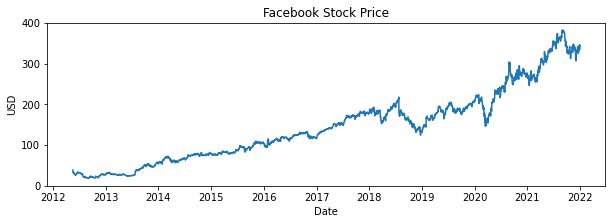

In [3]:
plotFacebookStock(data)

In [4]:
# Get technical features
technical_data = get_technical_indicators(data)
technical_data = technical_data.iloc[20:,:].reset_index(drop=True)

# Get Fourier features
fourier_data = get_fourier_transfer(technical_data)

# Get all features
data_final = pd.concat([technical_data, fourier_data], axis=1)

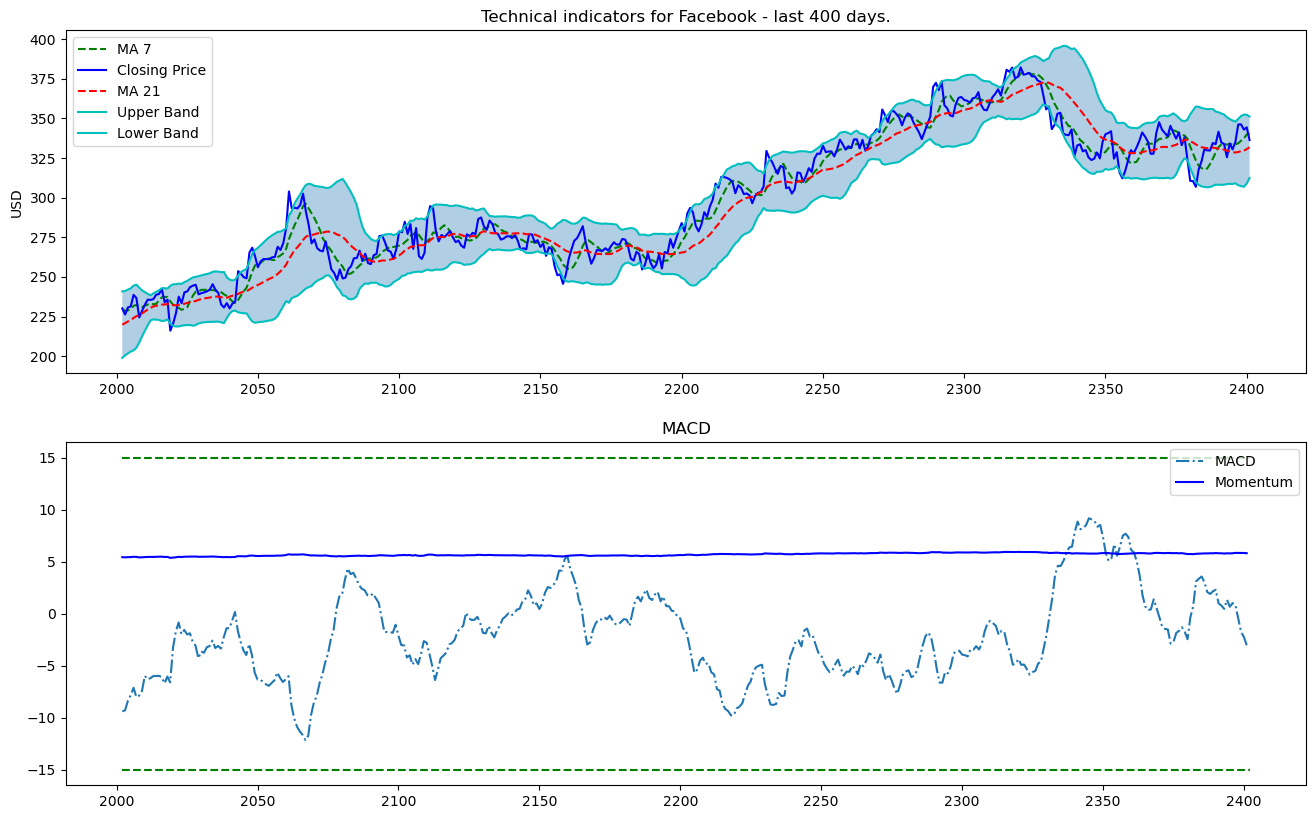

In [5]:
plot_technical_indicators(technical_data, 400)

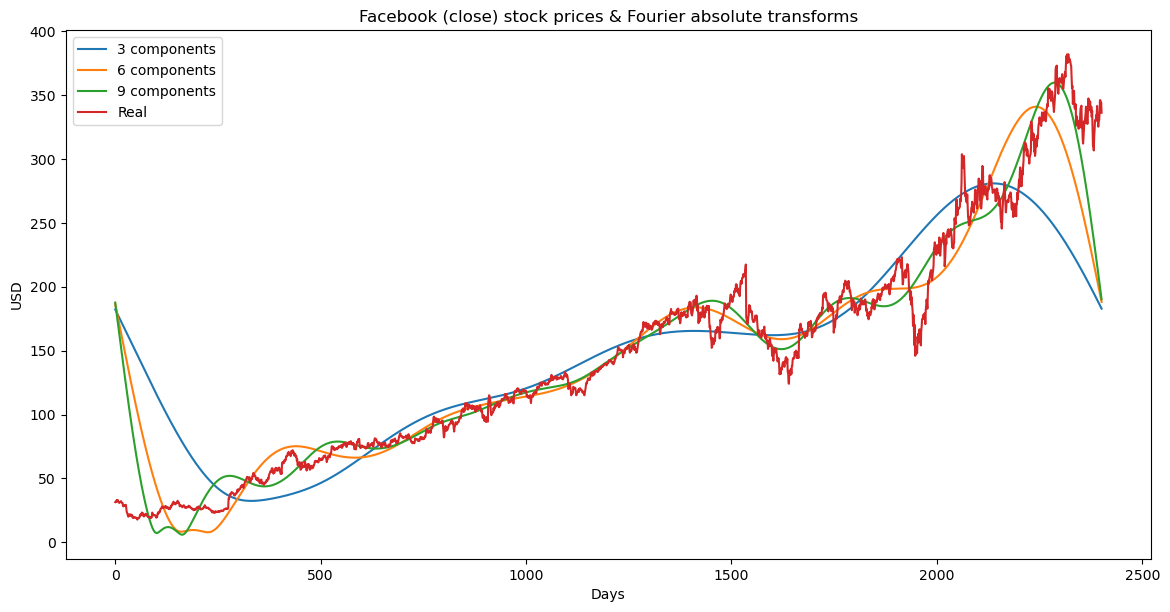

In [6]:
plot_Fourier(data_final)

In [7]:
manage_nan(data_final)
data_final = manage_dates(data_final)

In [8]:
# Get features and target
X = pd.DataFrame(data_final.iloc[:, :])
y = pd.DataFrame(data_final.iloc[:, 0])

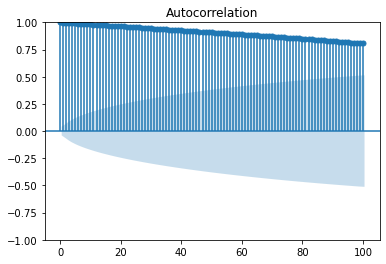

In [9]:
# Autocorrelation Check
sm.graphics.tsa.plot_acf(y.squeeze(), lags=100)
plt.show()

In [10]:
# Normalized the data
X_scaler_function = MinMaxScaler(feature_range=(-1, 1))
y_scaler_function = MinMaxScaler(feature_range=(-1, 1))

X_scaled = X_scaler_function.fit_transform(X)
y_scaled = y_scaler_function.fit_transform(y)

In [11]:
N_STEPS_IN = 3
N_STEPS_OUT = 1
pathToSave = r'Data\dataPreprocessed'
reshape_dataset(pathToSave, data_final, X_scaled, y_scaled, N_STEPS_IN, N_STEPS_OUT)

X shape:  (2399, 3, 36)
y shape:  (2399, 1)
X_train shape:  (1679, 3, 36)
y_train shape:  (1679, 1)
y_c_train shape:  (1679, 3, 1)
X_test shape:  (720, 3, 36)
y_test shape:  (720, 1)
y_c_test shape:  (720, 3, 1)
index_train shape: (1679,)
index_test shape: (720,)
Everything saved in  Data\dataPreprocessed


## Training

In [12]:
# Load data
path = r'Data\dataPreprocessed'
X_train = np.load(os.path.join(path, "X_train.npy"), allow_pickle=True)
y_train = np.load(os.path.join(path, "y_train.npy"), allow_pickle=True)
X_test = np.load(os.path.join(path, "X_test.npy"), allow_pickle=True)
y_test = np.load(os.path.join(path, "y_test.npy"), allow_pickle=True)
yc_train = np.load(os.path.join(path, "yc_train.npy"), allow_pickle=True)
yc_test = np.load(os.path.join(path, "yc_test.npy"), allow_pickle=True)

In [13]:
# Hyperparameter
EPOCHS = 100
BATCH_SIZE = 128
D_STEPS = 1
G_STEPS = 3
GP_WEIGHT = 10
D_LEARNING_RATE = 0.0001
G_LEARNING_RATE = 0.0001

In [14]:
input_generator_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_generator_dim = y_train.shape[1]

# Instantiate the optimizer for both networks
discriminator_optimizer = tf.keras.optimizers.Adam(D_LEARNING_RATE)
generator_optimizer = tf.keras.optimizers.Adam(G_LEARNING_RATE)

generator = Generator(input_generator_dim, output_generator_dim, feature_size)
generator.compile()
discriminator = Discriminator()
wgan_gp = WGAN_GP(generator, discriminator, Metric_rmse_scaled(y_scaler_function), D_STEPS, G_STEPS, GP_WEIGHT)

# Compile the WGAN model.
wgan_gp.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    d_loss_fn=discriminator_loss,
    g_loss_fn=generator_loss
)

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, yc_train))
dataset = dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test , y_test , yc_test ))
test_dataset = test_dataset.batch(BATCH_SIZE)

# Callback to save model
save_path = r'Models\trying'
EPOCH_MODEL_SAVE = 1

es = callbacks.EarlyStopping(monitor='val_rmse', mode='min', verbose=1, patience=20)
callback = [es, SaveModel(save_path, EPOCH_MODEL_SAVE), SaveBestModel(save_path)]

history = wgan_gp.fit(dataset, epochs=EPOCHS, callbacks=callback, validation_data=test_dataset)

Epoch 1/100
14/14 [==============================] - 22s 227ms/step - d_loss: 9.5278 - g_loss: -0.0306 - rmse: 407.8398 - val_d_loss: 9.5445 - val_g_loss: -0.0021 - val_rmse: 440.3503
Current best epoch:  1
Epoch 2/100
14/14 [==============================] - 2s 110ms/step - d_loss: 8.8854 - g_loss: -0.0935 - rmse: 1807.7099 - val_d_loss: 9.1519 - val_g_loss: 0.0623 - val_rmse: 1125.7826
Epoch 3/100
14/14 [==============================] - 2s 109ms/step - d_loss: 7.7938 - g_loss: -0.0155 - rmse: 1225.0327 - val_d_loss: 8.6010 - val_g_loss: 0.0206 - val_rmse: 331.5926
Current best epoch:  3
Epoch 4/100
14/14 [==============================] - 2s 109ms/step - d_loss: 6.9776 - g_loss: -0.1575 - rmse: 144.6002 - val_d_loss: 7.7458 - val_g_loss: 0.0349 - val_rmse: 384.9668
Epoch 5/100
14/14 [==============================] - 2s 113ms/step - d_loss: 5.1084 - g_loss: -0.2645 - rmse: 216.4941 - val_d_loss: 7.0515 - val_g_loss: 0.0245 - val_rmse: 188.2784
Current best epoch:  5
Epoch 6/100
14/1

14/14 [==============================] - 2s 145ms/step - d_loss: 0.0181 - g_loss: -1.0102 - rmse: 7.3733 - val_d_loss: 2.1249 - val_g_loss: 0.2272 - val_rmse: 42.6605
Epoch 45/100
14/14 [==============================] - 2s 137ms/step - d_loss: 0.0154 - g_loss: -1.0104 - rmse: 6.3850 - val_d_loss: 1.9883 - val_g_loss: 0.2358 - val_rmse: 12.5754
Epoch 46/100
14/14 [==============================] - 2s 137ms/step - d_loss: 0.0165 - g_loss: -0.9970 - rmse: 9.3293 - val_d_loss: 1.9520 - val_g_loss: 0.2433 - val_rmse: 19.1796
Epoch 47/100
14/14 [==============================] - 2s 144ms/step - d_loss: 0.0176 - g_loss: -0.9946 - rmse: 8.9056 - val_d_loss: 1.9170 - val_g_loss: 0.2464 - val_rmse: 21.1137
Epoch 48/100
14/14 [==============================] - 2s 165ms/step - d_loss: 0.0168 - g_loss: -0.9901 - rmse: 7.2146 - val_d_loss: 1.8580 - val_g_loss: 0.2475 - val_rmse: 17.3196
Epoch 49/100
14/14 [==============================] - 2s 162ms/step - d_loss: 0.0127 - g_loss: -0.9988 - rmse: 6.

Epoch 89/100
14/14 [==============================] - 2s 128ms/step - d_loss: 0.2433 - g_loss: -0.4949 - rmse: 74.9226 - val_d_loss: 0.3508 - val_g_loss: 0.4206 - val_rmse: 155.9209
Epoch 90/100
14/14 [==============================] - 2s 133ms/step - d_loss: 0.0214 - g_loss: -0.5520 - rmse: 29.3499 - val_d_loss: 0.4123 - val_g_loss: 0.4092 - val_rmse: 83.0515
Epoch 91/100
14/14 [==============================] - 2s 117ms/step - d_loss: 0.0275 - g_loss: -0.5476 - rmse: 14.4412 - val_d_loss: 0.4514 - val_g_loss: 0.3958 - val_rmse: 70.5029
Epoch 92/100
14/14 [==============================] - 2s 130ms/step - d_loss: 0.0151 - g_loss: -0.6311 - rmse: 12.1677 - val_d_loss: 0.4364 - val_g_loss: 0.3990 - val_rmse: 23.5776
Epoch 93/100
14/14 [==============================] - 2s 143ms/step - d_loss: 0.0017 - g_loss: -0.6164 - rmse: 14.5636 - val_d_loss: 0.3968 - val_g_loss: 0.4041 - val_rmse: 12.7900
Epoch 94/100
14/14 [==============================] - 2s 148ms/step - d_loss: -2.3722e-04 - g_

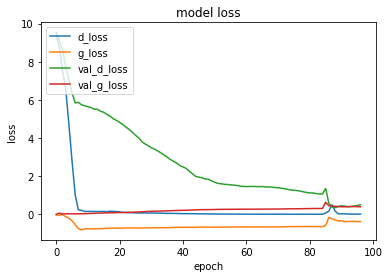

In [15]:
plot_loss(history)

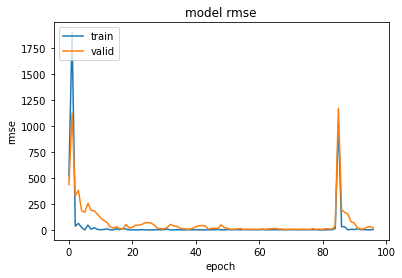

In [16]:
plot_rmse(history)

## Pred Test data

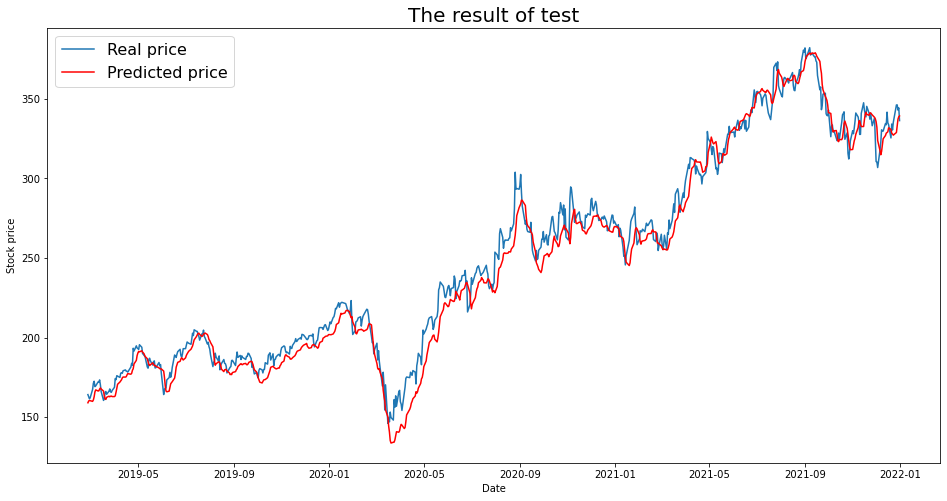

-- RMSE --  9.584296691146925


In [17]:
path = r'Data\dataPreprocessed'

# Load index
test_predict_index = np.load(os.path.join(path,"index_test.npy"), allow_pickle=True)

# Load test dataset/ model
G_model = models.load_model(r'Models\trying\wgan_gp_best.h5')
X_test = np.load(os.path.join(path,"X_test.npy"), allow_pickle=True)
y_test = np.load(os.path.join(path,"y_test.npy"), allow_pickle=True)

get_test_plot(X_test, y_test, G_model, y_scaler_function, test_predict_index)